# Entrenamientos de modelos

En este notebook se lleva a cabo el proceso de entrenamiento y optimización de los modelos predeterminados que serán utilizados en la API de inferencia desplegada con BentoML.

In [1]:
import pandas as pd
import joblib
import json

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

## Cargar dataset

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 4)

DATA_PATH = "data/Industrial_fault_detection.csv"
df = pd.read_csv(DATA_PATH)
print(f"Filas: {df.shape[0]:,}  |  Columnas: {df.shape[1]}")
df.head()

Filas: 1,000  |  Columnas: 37


,Temperature,Vibration,Pressure,Flow_Rate,Current,Voltage,FFT_Temp_0,FFT_Vib_0,FFT_Pres_0,FFT_Temp_1,FFT_Vib_1,FFT_Pres_1,FFT_Temp_2,FFT_Vib_2,FFT_Pres_2,FFT_Temp_3,FFT_Vib_3,FFT_Pres_3,FFT_Temp_4,FFT_Vib_4,FFT_Pres_4,FFT_Temp_5,FFT_Vib_5,FFT_Pres_5,FFT_Temp_6,FFT_Vib_6,FFT_Pres_6,FFT_Temp_7,FFT_Vib_7,FFT_Pres_7,FFT_Temp_8,FFT_Vib_8,FFT_Pres_8,FFT_Temp_9,FFT_Vib_9,FFT_Pres_9,Fault_Type
0,46.0061,2.0384,56.7758,6.1844,12.4095,215.7624,772.4031,32.4365,971.8053,3.7606,0.7340,30.8746,8.7876,1.1573,4.3689,22.0885,1.2900,33.9704,2.5275,0.4367,23.4286,2.2032,1.6654,25.8206,2.5275,0.4367,23.4286,22.0885,1.2900,33.9704,8.7876,1.1573,4.3689,3.7606,0.7340,30.8746,0
1,62.5292,2.5737,76.1598,8.2792,14.9064,215.4659,767.6024,32.3956,962.4815,8.3651,0.7246,27.2683,12.5535,1.1308,8.1044,19.4903,1.2831,41.3641,6.9389,0.4133,25.0722,7.0038,1.6244,35.1444,6.9389,0.4133,25.0722,19.4903,1.2831,41.3641,12.5535,1.1308,8.1044,8.3651,0.7246,27.2683,0
2,77.2950,3.2435,92.3726,9.1728,15.0541,202.0436,765.9651,32.0320,956.2995,9.5598,0.9344,30.1371,12.2918,0.8034,13.2624,21.1090,0.9723,43.4171,5.4635,0.5342,20.1791,5.3665,1.9880,28.9623,5.4635,0.5342,20.1791,21.1090,0.9723,43.4171,12.2918,0.8034,13.2624,9.5598,0.9344,30.1371,0
3,76.5642,3.1429,94.1496,13.7754,16.4179,216.6991,763.9364,33.0399,956.5322,10.2519,0.1692,29.9199,10.3211,1.1399,13.2934,20.8637,0.6063,43.6489,6.5774,1.1686,19.9480,7.3951,2.9958,28.7295,6.5774,1.1686,19.9480,20.8637,0.6063,43.6489,10.3211,1.1399,13.2934,10.2519,0.1692,29.9199,0
4,78.2816,3.1400,94.4410,11.1131,10.8994,227.3283,746.7549,33.0187,950.2128,18.3131,0.1727,36.0651,14.4416,1.1491,7.1494,8.1633,0.6273,45.4618,17.8478,1.1783,14.7549,9.7864,3.0169,22.4101,17.8478,1.1783,14.7549,8.1633,0.6273,45.4618,14.4416,1.1491,7.1494,18.3131,0.1727,36.0651,3


In [3]:
TARGET_COL = "Fault_Type"  

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print("X:", X.shape, "| y:", y.shape)


X: (1000, 36) | y: (1000,)


## Entrenamiento de los modelos

In [4]:
RANDOM_STATE = 10
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (800, 36) Test: (200, 36)


In [5]:
RANDOM_STATE = 10
CV = 5
N_JOBS = -1

#Se definen una serie de modelos base con distintas configuraciones de hyperparametros

models_and_grids = {
    "logreg": (
        Pipeline([
            ("scale", StandardScaler()),
            ("clf", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
        ]),
        {
            "clf__C": [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
            "clf__solver": ["lbfgs", "saga"],
        }
    ),

    "svm_rbf": (
        Pipeline([
            ("scale", StandardScaler()),
            ("clf", SVC())
        ]),
        {
            "clf__C": [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
            "clf__gamma": ["scale", "auto", 0.01, 0.05, 0.1, 0.2],
        }
    ),

    "knn": (
        Pipeline([
            ("scale", StandardScaler()),
            ("clf", KNeighborsClassifier())
        ]),
        {
            "clf__n_neighbors": list(range(3, 26, 2)),
            "clf__weights": ["uniform", "distance"],
            "clf__p": [1, 2],
        }
    ),

    "mlp": (
        Pipeline([
            ("scale", StandardScaler()),
            ("clf", MLPClassifier(max_iter=600, random_state=RANDOM_STATE))
        ]),
        {
            "clf__hidden_layer_sizes": [(50,), (100,), (100, 50), (200, 100)],
            "clf__activation": ["relu", "tanh"],
            "clf__alpha": [0.0001, 0.0005, 0.001, 0.005, 0.01],
        }
    ),

    "rf": (
        RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        {
            "n_estimators": [200, 400, 800],
            "max_depth": [None, 10, 20],
            "max_features": ["sqrt", "log2"],
        }
    ),

    "gb": (
        GradientBoostingClassifier(random_state=RANDOM_STATE),
        {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [2, 3, 4],
        }
    ),

    "hgb": (
        HistGradientBoostingClassifier(random_state=RANDOM_STATE),
        {
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [None, 3, 5],
            "max_leaf_nodes": [31, 63],
        }
    ),

    "xgb": (
        XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric="mlogloss",
            tree_method="hist",
        ),
        {
            "n_estimators": [200, 400],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
        }
    )
}

In [6]:
results = []
best_models = {}

out_dir = Path("artifacts/models_default")
out_dir.mkdir(parents=True, exist_ok=True)

for name, (estimator, param_grid) in models_and_grids.items():
    print(f"\n=== GridSearch: {name} ===")

    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring="accuracy",
        cv=CV,
        n_jobs=N_JOBS,
        verbose=0,
    )
    grid.fit(X_train, y_train)

    best = grid.best_estimator_
    best_models[name] = best

    y_pred = best.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    results.append({
        "model": name,
        "cv_best_acc": float(grid.best_score_),
        "test_acc": float(test_acc),
        "best_params": grid.best_params_,
    })

    joblib.dump(best, out_dir / f"{name}_best.joblib")
    print(f"{name}: cv={grid.best_score_:.4f} | test={test_acc:.4f}")



=== GridSearch: logreg ===
logreg: cv=0.7250 | test=0.7250

=== GridSearch: svm_rbf ===
svm_rbf: cv=0.7250 | test=0.7250

=== GridSearch: knn ===
knn: cv=0.7250 | test=0.7200

=== GridSearch: mlp ===


C:\Users\Alvaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


mlp: cv=0.6238 | test=0.5900

=== GridSearch: rf ===
rf: cv=0.7250 | test=0.7200

=== GridSearch: gb ===
gb: cv=0.7050 | test=0.7050

=== GridSearch: hgb ===
hgb: cv=0.7175 | test=0.7250

=== GridSearch: xgb ===
xgb: cv=0.7225 | test=0.7250


Los modelos se almacenan en formato .joblib, ya que es el método recomendado por scikit-learn para serializar pipelines completos de forma eficiente, reproducible y compatible con el despliegue posterior mediante BentoML

In [7]:
results_df = pd.DataFrame(results).sort_values("test_acc", ascending=False)
results_df

,model,cv_best_acc,test_acc,best_params
0,logreg,0.7250,0.725,"{'clf__C': 0.01, 'clf__solver': 'lbfgs'}"
1,svm_rbf,0.7250,0.725,"{'clf__C': 0.1, 'clf__gamma': 'scale'}"
6,hgb,0.7175,0.725,"{'learning_rate': 0.05, 'max_depth': 3, 'max_l..."
7,xgb,0.7225,0.725,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
4,rf,0.7250,0.720,"{'max_depth': None, 'max_features': 'sqrt', 'n..."
2,knn,0.7250,0.720,"{'clf__n_neighbors': 11, 'clf__p': 1, 'clf__we..."
5,gb,0.7050,0.705,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est..."
3,mlp,0.6238,0.590,"{'clf__activation': 'tanh', 'clf__alpha': 0.00..."


Como se puede apreciar, la mayoría de modelos rondan un accuracy del 72.5%, por lo que es conveniente hacer un analisis para comprobar a que se debe esto.

## Análisis detallado de resultados

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Comparación de métricas entre modelos

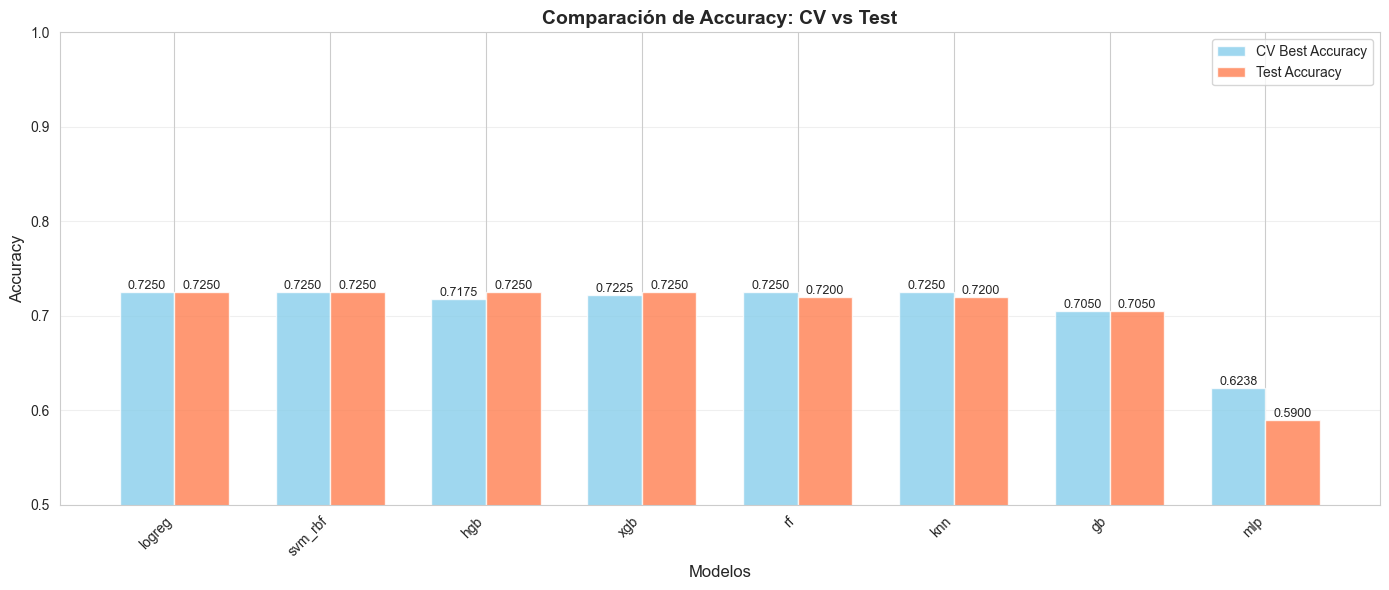

In [9]:
# Gráfico de barras comparando CV accuracy vs Test accuracy
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

models = results_df['model'].values
cv_scores = results_df['cv_best_acc'].values
test_scores = results_df['test_acc'].values

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, cv_scores, width, label='CV Best Accuracy', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, test_scores, width, label='Test Accuracy', alpha=0.8, color='coral')

ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Comparación de Accuracy: CV vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.5, 1.0])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 2. Matrices de confusión para todos los modelos

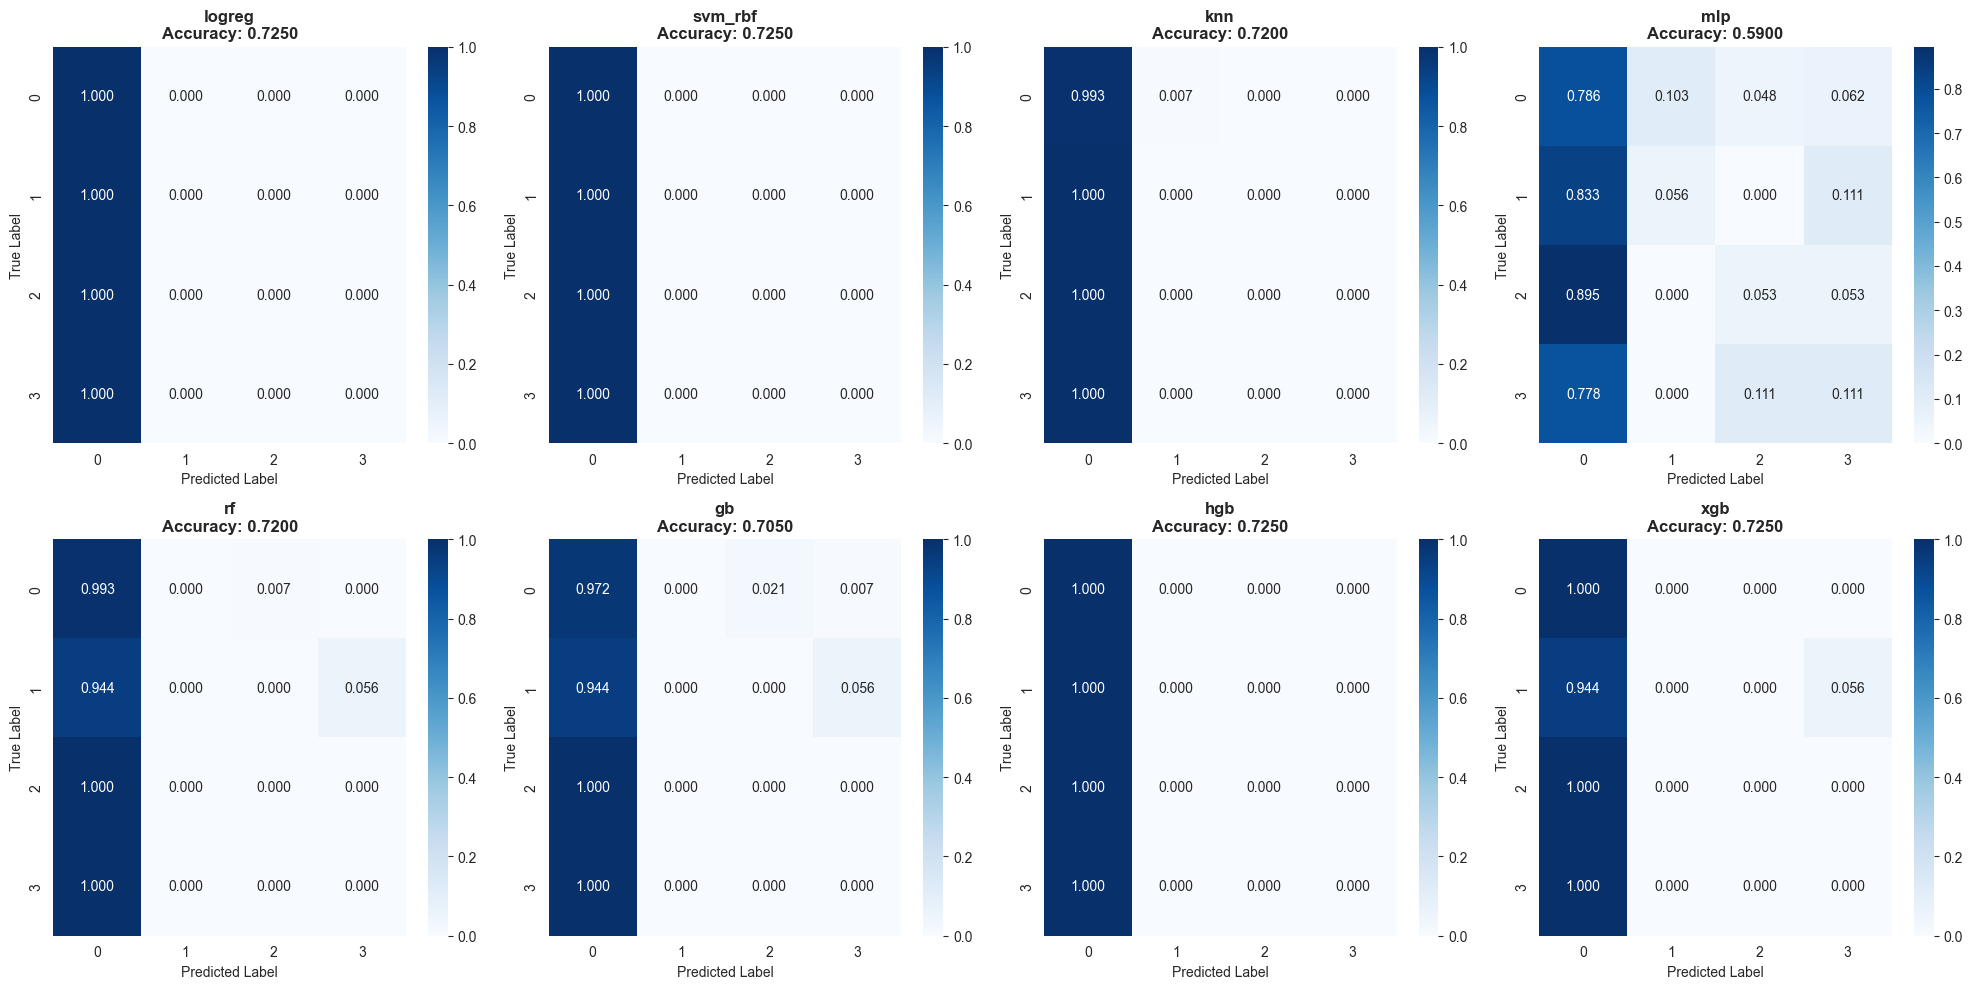

In [10]:
# Generar predicciones para todos los modelos
preds = {}
for name, model in best_models.items():
    preds[name] = model.predict(X_test)

# Crear subplot para todas las matrices de confusión
n_models = len(best_models)
n_cols = 4
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

classes = sorted(y_test.unique())

for idx, (name, y_pred) in enumerate(preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
                ax=axes[idx], cbar=True, 
                xticklabels=classes, yticklabels=classes)
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, y_pred):.4f}', 
                        fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 3. F1-Score

C:\Users\Alvaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Alvaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Alvaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_c

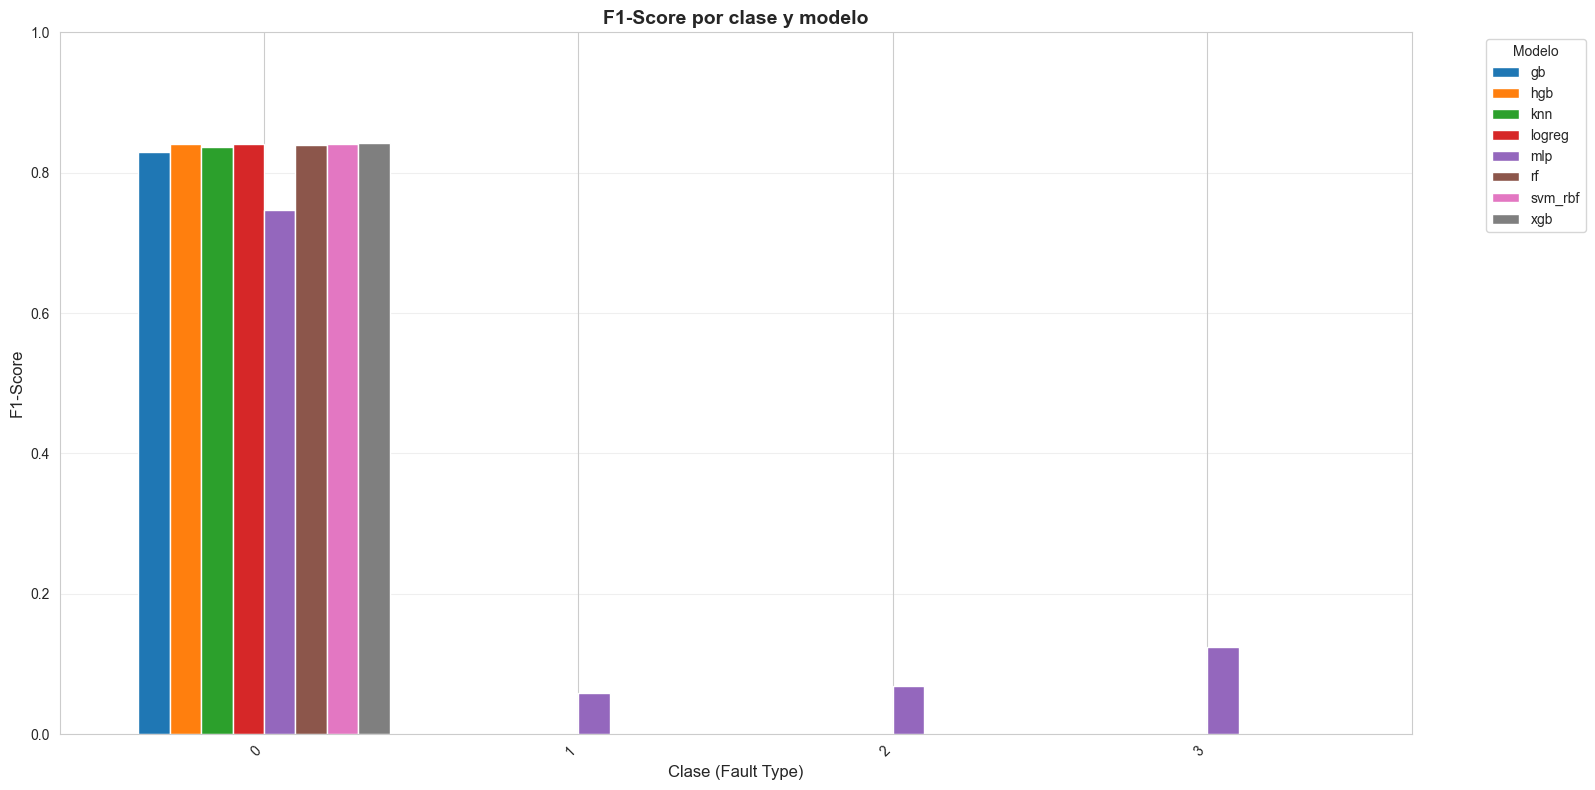

In [11]:
#Crear eval_df con métricas por clase y modelo
eval_data = []
for name in preds.keys():
	report = classification_report(y_test, preds[name], output_dict=True)
	for class_label in classes:
		class_label_str = str(class_label)
		if class_label_str in report:
			eval_data.append({
				'model': name,
				'class': class_label,
				'f1-score': report[class_label_str]['f1-score'],
				'precision': report[class_label_str]['precision'],
				'recall': report[class_label_str]['recall']
			})

eval_df = pd.DataFrame(eval_data)

# Visualización de F1-Score por clase y modelo
fig, ax = plt.subplots(figsize=(16, 8))

pivot_f1 = eval_df.pivot(index='class', columns='model', values='f1-score')
pivot_f1.plot(kind='bar', ax=ax, width=0.8)

ax.set_title('F1-Score por clase y modelo', fontsize=14, fontweight='bold')
ax.set_xlabel('Clase (Fault Type)', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.0, 1.0])

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4. Análisis de casos mal clasificados

Total de errores: 55 de 200 (27.50%)
Accuracy: 0.7250

Distribución de errores por clase:
   Errores  Total  Tasa de Error
0      0.0  145.0            0.0
1     18.0   18.0            1.0
2     19.0   19.0            1.0
3     18.0   18.0            1.0


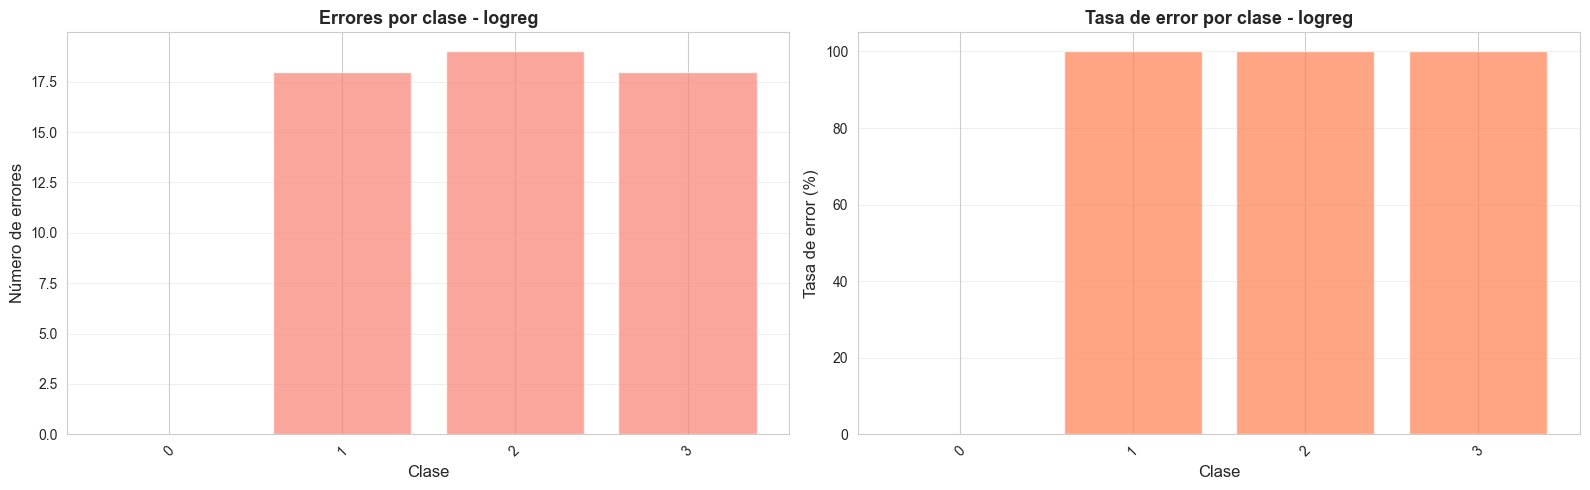

In [12]:
best_model_name = results_df.iloc[0]['model']
best_pred = preds[best_model_name]
errors = best_pred != y_test

print(f"Total de errores: {errors.sum()} de {len(y_test)} ({errors.sum()/len(y_test)*100:.2f}%)")
print(f"Accuracy: {accuracy_score(y_test, best_pred):.4f}\n")

# Distribución de errores por clase
error_by_class = {}
for class_label in classes:
    mask = y_test == class_label
    class_errors = (best_pred[mask] != y_test[mask]).sum()
    class_total = mask.sum()
    error_by_class[class_label] = {
        'errors': class_errors,
        'total': class_total,
        'error_rate': class_errors / class_total if class_total > 0 else 0
    }

error_df = pd.DataFrame(error_by_class).T
error_df.columns = ['Errores', 'Total', 'Tasa de Error']
print("Distribución de errores por clase:")
print(error_df)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Número de errores por clase
axes[0].bar(error_df.index.astype(str), error_df['Errores'], color='salmon', alpha=0.7)
axes[0].set_xlabel('Clase', fontsize=12)
axes[0].set_ylabel('Número de errores', fontsize=12)
axes[0].set_title(f'Errores por clase - {best_model_name}', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Tasa de error por clase
axes[1].bar(error_df.index.astype(str), error_df['Tasa de Error']*100, color='coral', alpha=0.7)
axes[1].set_xlabel('Clase', fontsize=12)
axes[1].set_ylabel('Tasa de error (%)', fontsize=12)
axes[1].set_title(f'Tasa de error por clase - {best_model_name}', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 8. Resumen comparativo final

In [13]:
# Crear tabla resumen con todas las métricas
comparison_df_all = results_df.copy()

# Añadir métricas macro avg
macro_metrics = []
for name in comparison_df_all['model']:
    if name in preds:
        report = classification_report(y_test, preds[name], output_dict=True)
        macro_metrics.append({
            'model': name,
            'precision_macro': report['macro avg']['precision'],
            'recall_macro': report['macro avg']['recall'],
            'f1_macro': report['macro avg']['f1-score']
        })

macro_df = pd.DataFrame(macro_metrics)
comparison_df_all = comparison_df_all.merge(macro_df, on='model', how='left')

column_order = ['model', 'test_acc', 'cv_best_acc', 
                'f1_macro', 'precision_macro', 'recall_macro', 'best_params']
comparison_df_all = comparison_df_all[column_order]

comparison_df_all.sort_values('test_acc', ascending=False)

C:\Users\Alvaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Alvaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Alvaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_c

,model,test_acc,cv_best_acc,f1_macro,precision_macro,recall_macro,best_params
0,logreg,0.725,0.7250,0.2101,0.1812,0.2500,"{'clf__C': 0.01, 'clf__solver': 'lbfgs'}"
1,svm_rbf,0.725,0.7250,0.2101,0.1812,0.2500,"{'clf__C': 0.1, 'clf__gamma': 'scale'}"
2,hgb,0.725,0.7175,0.2101,0.1812,0.2500,"{'learning_rate': 0.05, 'max_depth': 3, 'max_l..."
3,xgb,0.725,0.7225,0.2108,0.1822,0.2500,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
4,rf,0.720,0.7250,0.2099,0.1818,0.2483,"{'max_depth': None, 'max_features': 'sqrt', 'n..."
5,knn,0.720,0.7250,0.2093,0.1809,0.2483,"{'clf__n_neighbors': 11, 'clf__p': 1, 'clf__we..."
6,gb,0.705,0.7050,0.2074,0.1808,0.2431,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est..."
7,mlp,0.590,0.6238,0.2501,0.2545,0.2514,"{'clf__activation': 'tanh', 'clf__alpha': 0.00..."


A partir de estos datos, es fácil ver que todos los modelos tienden a predecir la clase 0 (la mayoritaria), y por tanto obtienen casi siempre tanta puntuación como casos de la clase 0 haya. Hemos probado a darles más peso a las otras clases para tratar de resolver este problema, pero los resultados empeoran siempre. Es muy probable que este dataset sintético no contenga suficiente información como para poder distinguir el tipo de error a partir de los datos (quizás se generan de forma aleatoria), y por tanto 0.725 es el techo alcanzable.

In [14]:
#Guardar para usar en la API
out_dir = Path("artifacts/models_default")
out_dir.mkdir(parents=True, exist_ok=True)

feature_names = list(X.columns)
(out_dir / "feature_names.json").write_text(json.dumps(feature_names, indent=2), encoding="utf-8")
print("Guardado feature_names.json con", len(feature_names), "features")

Guardado feature_names.json con 36 features


## ANÁLISIS DE IDONEIDAD DE LOS MODELOS

Los resultados obtenidos no son del todo satisfactorios, pero no por eso son menos interesantes, pues se han obtenido resultados tan similares entre modelos muy diferentes. Para realizar una comparativa razonable entre los modelos aquí utilizados y entender cómo afectan los parámetros seleccionados a los resultados es preciso primero explicar en que consisten estos métodos. A continuación se hablará de los algoritmo s utilizados en el orden anteriormente presentado, en función de los resultados obtenidos (de mayor a menor). 

La regresión logística es conceptualmente un clasificador lineal, que intenta calcular una linea que separe los casos positivos de los negativos en fallas. Para ello asigna a cada vairable un peso o coficiente indicando como influye este en la probabilidad de falla. El parámetro más importante en el entrenamiento de este modelo es C, que representa la regularización, lo que especifica cuánto se le permite al modelo ajustarse a los datos de entrenamiento. Un valor de C bajo simplifica el modelo, evitando que memorice el ruido de los sensores, mientras que un valor de C alto permite al modelo ajustarse a cada pequeño dato. Como valor optimo se ha obtenido 0.01, el más pequeño de todos, lo que indica que el modelo prefiere ser simple para generalizar mejor. El resultado de este modelo a sido de una accuracy del 72.5% en la Cross-Validation, lo que significa que el 72.5% de las fallas se pueden detectar con reglas lineales relativamente simples, lo que a su vez se respalda con el hecho de que modelos más complejos no han superado por mucho a este modelo, sugieriendo que la relación entre las variables es bastante directa o que faltan variables clave para realizar predicciones de mayor calidad. 

En cuanto a Support Vector Machines, este es un algoritmo que intenta construir la línea más ancha posible entre los ejemplos con y sin fallas del conjunto de datos, siendo los bordes que tocan esta línea los vectores de soporte, especiales por ser los casos más dificiles de clasificar. En modelo SVM utiliza el kernel RBF (Radial Basis Function) para aumentar la dimensionalidad de las instancias de datos en el espacio de puntos y así poder distinguir un plano más claro para separar las instancias en positivas y negativas. En este caso también cobran sentido los parámetros C de regularización y gamma, que define cómo de influente es un solo punto de entrenamiento dependiendo de la distancia a la que están con respecto a la frontera. En este caso se opta por un valor de regularización pequeño, es decir, se opta por ignorar detalles finos y el ruido de los sensores y así generalizar mejor; y en el caso de gamma se opta por la opción automática que calcula la influencia óptima. Destaca al idoneidad de este modelo frente a la regresión logística, pues to que este está pensado para trabajar con datos de gran dimensionalidad (como es el caso de este dataset con tantas varibales de sensores). Asimismo, no es tan sensible a los outliers, pues SVM define la frontera basándose solo en los vectores de soporte (los puntos cercanos al límite), puesto que los alejados de la frontera son ignorados matemáticamente.

Por otro lado, el Histogram-based Gradient Boosting es un modelo que construye una secuencia de árboles de decisión en la que el primero realiza una predicción, y los sucesivos predicen el fallo realizado por el primero, definido como aprendizaje del residuo. Tal y como se muestra en los resultados de arriba, el algoritmo convergió con una profundidad máxima de 3, lo que sugiere que el problema de la detección de fallas no requiere una lógica muy compleja, sino que es posible explicarlo mediante interacciones sencillas entre no más de tres variables simultáneas. 

Relacionado con el modelo anterior está Extreme Gradient Boosting (XGB), el cual comparte el núcleo teórico con HGB pero se distingue porque integra regularización avanzada, penalizando la complejidad de los árboles a medida que se construye. Los parámetros de max_depth y learning_rate son los mismos que en el caso anterior y destacan subsample y colsample_bytree (con un valor de 0.8). Los que muestran que el modelo solo utilizó el 80% de las filas y columnas de datos disponibles al azar. Con esto se obliga al modelo a ser más generalista, lo que conceptualente es más positivo, y por lo visto tampoco perjudica, pues ha logrado resultados similares a los anteriores modelos (0.7225).

En lo que respecta a random forest, este algoritmo toma los resultados de varios árboles de decisión, menos precisos, para producir una decisión final. En este caso contrasta con los resultados de los anteriores en que no hubo profundidad máxima de los árboles, permitiendo que estos crezcan hasta aprender detalles muy concretos, aunque este riesgo se neutraliza mediante aleatoriedad. Asimismo, solo se le permite usar un subconjunto de los datos, evitando que un sensor domine frente a los otros. 

Al contrario que los modelos anteriormente descritos, k-Nearest Neighbour aprende nada durante el entrenamiento, pues calsifica los casos en función de los casos más similares en el espacio de puntos en el que se representan. Lo más remarkable aquí es que el algoritmo ha seleccionado 11 como el número de vecinos necesario para estimar si un caso resultará en fallo o no. Esto permite hacer frente al ruido y no fiarse únicamente en los casos más extrictamente similares al caso que se quiere predecir. 

Gradient Boosting se presenta como la implementación clásica del algoritmo de potenciación del gradiente. El funcionamiento de este algoritmo consiste en que secuencialmente lso árboles intentan mejorar el árbol anterior intentando clasificar los casos más complejos. En comparación con HGB y XGB, la versión clásica se estancó en una profundidad de 2, es decir, se limitó a interacciones muy básicas de pares de variables para realizar las predicciones, no logrando capturar la complejidad total de la falla. Esto explicaría la ligera caida en lso resultados. Este modelo es útil por el baseline que ofrece para comparar otros modelos con funcionalidades más avanzadas, como los anteriormente descritos. 

Finalmente, el Multi Layer Perceptron es el que ofreció los peores resultados. En este caso, se pasan los datos de entrada a través de capas de neuronas que aplican transformaciones lineales seguida de una función de activación. Según el GridSearch el parámetro óptimo de layers es una sola capa oculta de 100 neuronas. Comparando con el modelo inicial de la regresión logística, cabe destacar que en este caso la complejidad no influye positivamente en los resultados, y muestra que la estructura de las fallas no requiere de la abstracción profunda de una red neuronal. 